# Feature Selection Methods

In [56]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
np.set_printoptions(threshold=np.nan)

In [57]:
wine=pd.read_csv('winequality-red.csv',sep=';')
wine['quality']=wine['quality'].replace(6,1).replace(7,1).replace(8,1).replace(3,0).replace(4,0).replace(5,0)
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,0


In [58]:
len(wine)

1599

In [59]:
from sklearn.cross_validation import train_test_split

train, test = train_test_split(wine, test_size = 0.30, random_state=4444)
x_train=train.iloc[:,:11]
y_train=train.iloc[:,11]
x_test=test.iloc[:,:11]
y_test=test.iloc[:,11]
x=wine.iloc[:,:11]
y=wine.iloc[:,11]

# PCA

-PCA uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables (principal components).  

-Number of principal components is <= number of original variables.  

-First principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors are an uncorrelated orthogonal basis set. 

[Thanks wikipedia!](https://en.wikipedia.org/wiki/Principal_component_analysis)

Import the model: 

In [60]:
from sklearn.decomposition import PCA

Instantiate the model:

In [61]:
#Set number of components to keep
pca = PCA(n_components=3)

Fit to training data: 

In [62]:
pca.fit(x)

print(x.shape)

(1599, 11)


Transform to lower dimensional representation: 

In [63]:
X_pca = pca.transform(x)
X_pca.shape

(1599, 3)

In [64]:
X_pca[:10]

array([[ 13.22490501,  -2.02389981,   1.12682053],
       [-22.03772361,   4.40832155,   0.31037799],
       [ -7.16267333,  -2.50146086,   0.5818683 ],
       [-13.43006283,  -1.95112215,  -2.63403954],
       [ 13.22490501,  -2.02389981,   1.12682053],
       [  6.93400027,  -1.38790176,   1.12127705],
       [-12.03682832,  -3.61177553,   0.67163691],
       [ 25.04255804,   4.72607199,   1.33781652],
       [ 29.2756982 ,  -0.47905559,   0.72624845],
       [-54.46316749, -10.99931637,  -0.16155938]])

Find percentage of variance explained by the selected components:

In [65]:
print pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()

[ 0.94657698  0.0483683   0.00258917]
0.997534452799


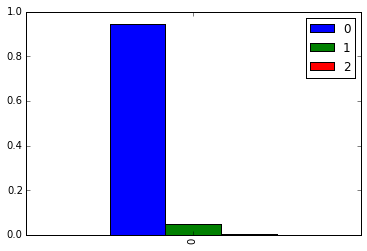

In [66]:
df = pd.DataFrame.from_records([map(float,pca.explained_variance_ratio_)])
df.plot(kind='bar')

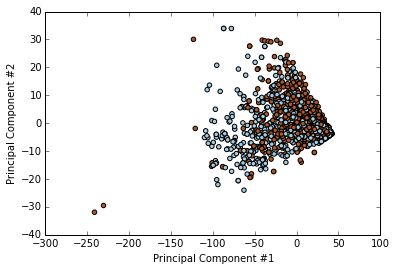

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y,cmap=plt.cm.Paired)
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')
plt.legend()

[]

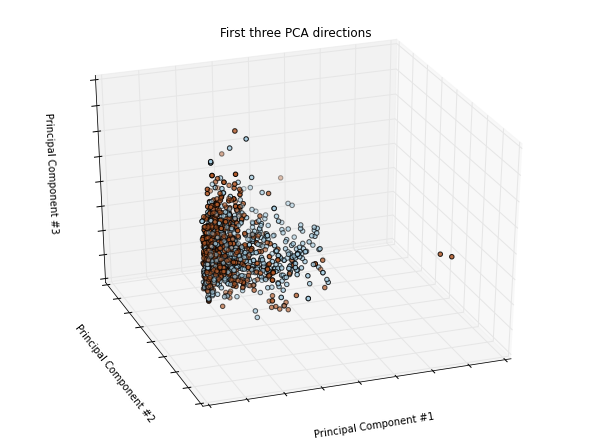

In [68]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(x,y)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Paired)
ax.set_title("First three PCA directions")
ax.set_xlabel("Principal Component #1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("Principal Component #2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Principal Component #3")
ax.w_zaxis.set_ticklabels([])


# Feature importances with tree-based methods:

-The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable.  

-Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples.  

-The expected fraction of the samples they contribute to can be used as an estimate of the relative importance of the features.

[Thanks scikit-learn documentation!](http://scikit-learn.org/stable/modules/ensemble.html#feature-importance-evaluation)

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from collections import defaultdict

#Note: min_samples_split = the minimum number of samples required to split an internal node
param={'max_depth':[1,10],'max_features':[1,11],'min_samples_split':(25,50,75,100,200,300,500)}
clf=RandomForestClassifier()

In [70]:
def GS_RF(x_train, y_train, parameters, model, s, title):
    scores=['accuracy','precision','recall','f1']
    mod_dict=defaultdict(list)
    
    for score in scores:
        gs = GridSearchCV(model,parameters,cv=5,scoring=score)
        gs.fit(x_train,y_train)
        print score,gs.best_estimator_
        mod_dict[score]=gs.best_estimator_ #estimator which gave highest score in the search
    best_model=mod_dict[s] #choose model optimized for the scoring system you want
    best_model.fit(x_train,y_train)
    
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10,8))
    plt.title("Feature importances based on {}: {}".format(s,title),fontsize=15)
    plt.bar(range(x_train.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(x_train.shape[1]), [list(x_train.columns.values)[i] for i in indices],rotation=45,fontsize=12)
    plt.xlim([-1, x_train.shape[1]])
    plt.show()

accuracy RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=11, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=25,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
precision RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=11, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=25,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
recall RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features=1, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=25,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
         

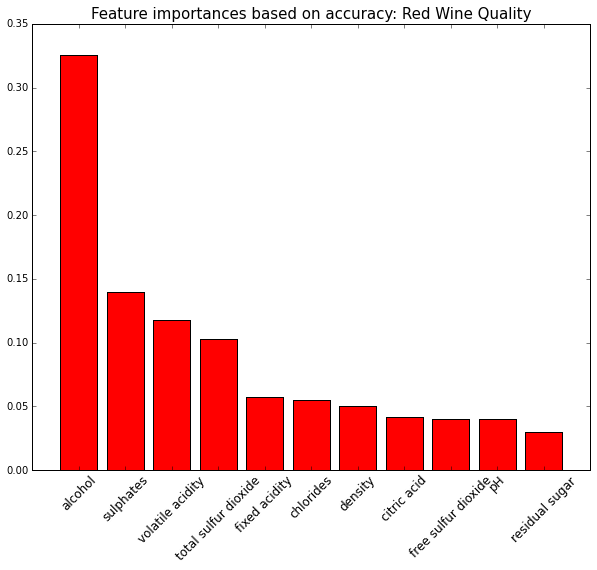

In [71]:
GS_RF(x_train,y_train,param,clf,'accuracy','Red Wine Quality')

# Variance Threshold:

Remove all features that do not satisfy a certain variance threshold: 
    
[Read more here](http://scikit-learn.org/stable/modules/feature_selection.html)

In [72]:
from sklearn.feature_selection import VarianceThreshold

In [74]:
#example: If you have Boolean features and want only those with 1 or 0 in > 80% of the of the samples, 
#set threshold = 0.8(1-0.8) -->Variance for Bernoulli Distribution

sel = VarianceThreshold(threshold=0.5) 

Show data coming from features with variance > specified value: 

In [75]:
x_new=sel.fit_transform(x,y)

See how many features meet your threshold:

In [76]:
x_new.shape

(1599, 5)

In [79]:
x_new[:10]

array([[   7.4,    1.9,   11. ,   34. ,    9.4],
       [   7.8,    2.6,   25. ,   67. ,    9.8],
       [   7.8,    2.3,   15. ,   54. ,    9.8],
       [  11.2,    1.9,   17. ,   60. ,    9.8],
       [   7.4,    1.9,   11. ,   34. ,    9.4],
       [   7.4,    1.8,   13. ,   40. ,    9.4],
       [   7.9,    1.6,   15. ,   59. ,    9.4],
       [   7.3,    1.2,   15. ,   21. ,   10. ],
       [   7.8,    2. ,    9. ,   18. ,    9.5],
       [   7.5,    6.1,   17. ,  102. ,   10.5]])

In [80]:
print [str((x.columns.values)[i]) for i in sel.get_support(indices=True)]

['fixed acidity', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol']


# SelectKBest:

In [86]:
from sklearn.feature_selection import SelectKBest,chi2

Using chi2 as a scoring function:  

-select the n_features with the highest values for the test chi-squared statistic from X  

-Recall that the chi-square test measures dependence between stochastic variables, so using this function “weeds out”
the features that are the most likely to be independent of class and therefore irrelevant for classification.

[More info on Chi-squared](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html)

In [87]:
a=SelectKBest(chi2, k=5)
a.fit_transform(x, y)[:10]

array([[  7.00000000e-01,   0.00000000e+00,   1.10000000e+01,
          3.40000000e+01,   9.40000000e+00],
       [  8.80000000e-01,   0.00000000e+00,   2.50000000e+01,
          6.70000000e+01,   9.80000000e+00],
       [  7.60000000e-01,   4.00000000e-02,   1.50000000e+01,
          5.40000000e+01,   9.80000000e+00],
       [  2.80000000e-01,   5.60000000e-01,   1.70000000e+01,
          6.00000000e+01,   9.80000000e+00],
       [  7.00000000e-01,   0.00000000e+00,   1.10000000e+01,
          3.40000000e+01,   9.40000000e+00],
       [  6.60000000e-01,   0.00000000e+00,   1.30000000e+01,
          4.00000000e+01,   9.40000000e+00],
       [  6.00000000e-01,   6.00000000e-02,   1.50000000e+01,
          5.90000000e+01,   9.40000000e+00],
       [  6.50000000e-01,   0.00000000e+00,   1.50000000e+01,
          2.10000000e+01,   1.00000000e+01],
       [  5.80000000e-01,   2.00000000e-02,   9.00000000e+00,
          1.80000000e+01,   9.50000000e+00],
       [  5.00000000e-01,   3.6000000

In [88]:
a.scores_

array([  5.26525668e+00,   1.00297102e+01,   5.66670287e+00,
         5.84022628e-03,   4.85195914e-01,   4.20059068e+01,
         2.00230590e+03,   1.44572025e-04,   1.22551075e-04,
         3.31761735e+00,   3.29086327e+01])

In [89]:
a.pvalues_

array([  2.17552144e-02,   1.54035272e-03,   1.72899237e-02,
         9.39083866e-01,   4.86078160e-01,   9.09981237e-11,
         0.00000000e+00,   9.90406618e-01,   9.91167376e-01,
         6.85410969e-02,   9.65933872e-09])

In [90]:
indices_s = np.argsort(a.scores_)[::-1]
indices_p = np.argsort(a.pvalues_)

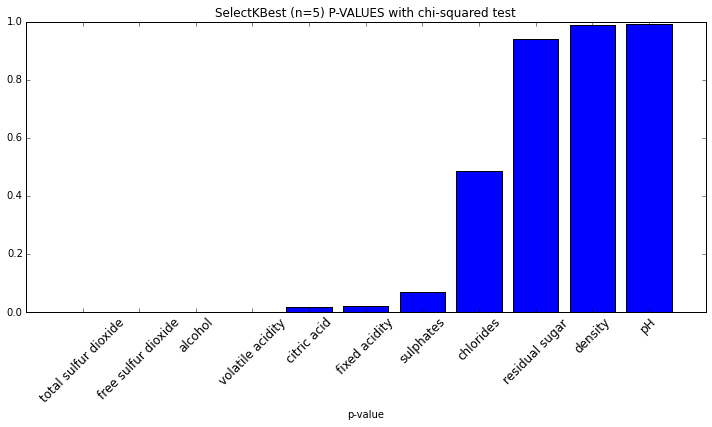

In [93]:
"""plt.figure(figsize=(12,8))
#plt.subplot(1,2,1)
plt.title("SelectKBest (n=5) SCORES with chi-squared test",fontsize=12)
plt.bar(range(x_train.shape[1]), a.scores_[indices_s], color="r", align="center")
plt.xticks(range(x_train.shape[1]), [list(x_train.columns.values)[i] for i in indices_s],rotation=45,fontsize=12)
plt.xlim([-1, x_train.shape[1]])
plt.xlabel('Score')"""

plt.figure(figsize=(10,6))
plt.title("SelectKBest (n=5) P-VALUES with chi-squared test",fontsize=12)
plt.bar(range(x_train.shape[1]), a.pvalues_[indices_p], color="b", align="center")
plt.xticks(range(x_train.shape[1]), [list(x_train.columns.values)[i] for i in indices_p],rotation=45,fontsize=12)
plt.xlim([-1, x_train.shape[1]])
plt.xlabel('p-value')

plt.tight_layout()

# SelectFromModel:

Selects non-zero coefficients from linear models penalized with the L1 norm.

[More info here](http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel)

In [32]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

With Logistic Regression:

In [33]:
rgr = LogisticRegression(C=0.01, penalty="l1", dual=False).fit(x, y) 
#penalty is L1 regularization
#C is inverse of regularization strength (Smaller values have stronger regularization)

LRmodel = SelectFromModel(rgr, prefit=True)
x_new = LRmodel.transform(x)
x_new.shape

(1599, 3)

In [34]:
x_new[:10]

array([[  11. ,   34. ,    9.4],
       [  25. ,   67. ,    9.8],
       [  15. ,   54. ,    9.8],
       [  17. ,   60. ,    9.8],
       [  11. ,   34. ,    9.4],
       [  13. ,   40. ,    9.4],
       [  15. ,   59. ,    9.4],
       [  15. ,   21. ,   10. ],
       [   9. ,   18. ,    9.5],
       [  17. ,  102. ,   10.5]])

In [35]:
print [str((x.columns.values)[i]) for i in LRmodel.get_support(indices=True)]

['free sulfur dioxide', 'total sulfur dioxide', 'alcohol']


In [36]:
lrc=pd.DataFrame({"L1 Regularization coefficients":np.concatenate(rgr.coef_)},index=[str(i) for i in x.columns.values])
lrc

,L1 Regularization coefficients
fixed acidity,0.000000
volatile acidity,0.000000
citric acid,0.000000
residual sugar,0.000000
chlorides,0.000000
free sulfur dioxide,0.025900
total sulfur dioxide,-0.022863
density,0.000000
pH,0.000000
sulphates,0.000000


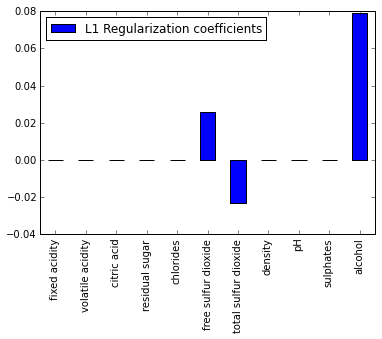

In [37]:
lrc.plot(kind='bar')

With SVM:

[More on LinearSVC here](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

In [94]:
supvec=LinearSVC(C=0.01,penalty="l1", dual=False).fit(x,y)
SVCmodel = SelectFromModel(supvec, prefit=True)
x_new2 = SVCmodel.transform(x)
x_new2.shape

(1599, 6)

In [95]:
x_new2[:10]

array([[   7.4 ,    0.7 ,   11.  ,   34.  ,    3.51,    9.4 ],
       [   7.8 ,    0.88,   25.  ,   67.  ,    3.2 ,    9.8 ],
       [   7.8 ,    0.76,   15.  ,   54.  ,    3.26,    9.8 ],
       [  11.2 ,    0.28,   17.  ,   60.  ,    3.16,    9.8 ],
       [   7.4 ,    0.7 ,   11.  ,   34.  ,    3.51,    9.4 ],
       [   7.4 ,    0.66,   13.  ,   40.  ,    3.51,    9.4 ],
       [   7.9 ,    0.6 ,   15.  ,   59.  ,    3.3 ,    9.4 ],
       [   7.3 ,    0.65,   15.  ,   21.  ,    3.39,   10.  ],
       [   7.8 ,    0.58,    9.  ,   18.  ,    3.36,    9.5 ],
       [   7.5 ,    0.5 ,   17.  ,  102.  ,    3.35,   10.5 ]])

In [96]:
lsvc=pd.DataFrame({"Linear SVC Regularization coefficients":np.concatenate(supvec.coef_)},index=[str(i) for i in x.columns.values])
lsvc

,Linear SVC Regularization coefficients
fixed acidity,-0.008470
volatile acidity,-0.481217
citric acid,0.000000
residual sugar,0.000000
chlorides,0.000000
free sulfur dioxide,0.012025
total sulfur dioxide,-0.008457
density,0.000000
pH,-0.566169
sulphates,0.000000


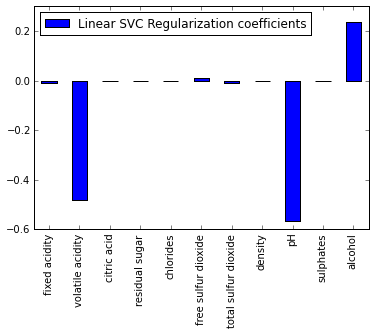

In [97]:
lsvc.plot(kind='bar')

**NOTE**: This can also be applied to regression cases with linear_model.Lasso

# Recursive Feature Elimination:

In [98]:
from sklearn.feature_selection import RFE

-RFE selects features by recursively considering smaller and smaller sets of features.  
-Estimator is trained on the initial set of features and weights are assigned to each one of them.  
-Features whose absolute weights are the smallest are pruned from the current set features.  
-That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

[More info on RFE here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

In [99]:
#Estimator must have a fit method that updates a coef_ attribute (can also use SVC). 
#Important features must correspond to high absolute values in the coef_ array

rfe = RFE(LogisticRegression(), 5)
rfe = rfe.fit(x, y)

In [100]:
print(rfe.support_)
print(rfe.ranking_) #selected features are assigned Rank 1

[False  True False False  True False False  True  True  True False]
[7 1 2 4 1 5 6 1 1 1 3]


In [101]:
[str((x.columns.values)[i]) for i in range(len(rfe.ranking_)) if rfe.ranking_[i]==1]

['volatile acidity', 'chlorides', 'density', 'pH', 'sulphates']

# Pearson Correlation:

In [46]:
from scipy.stats import pearsonr
import numpy as np

-The Pearson correlation coefficient measures the linear relationship between two datasets.  
(Assuming data set is normally distributed)  

-Varies between -1 and +1 with 0 implying no correlation.  
**NOTE**: Pearson Correlation of 0 does not imply independence.  

-Positive correlations imply that as x increases, so does y.  
-Negative correlations imply that as x increases, y decreases.  

-The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets. 

[Pearson Correlation refresher](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient)

In [102]:
pearcorr=[]
pval=[]
for i in range(len(x.columns)):
    pearcorr.append(pearsonr(x.iloc[:,i],y)[0])
    pval.append(pearsonr(x.iloc[:,i],y)[1])
pcorr=pd.DataFrame({"Pearson Correlation":pearcorr,"p-value":pval},index=[str(i) for i in x.columns.values])
pcorr

,Pearson Correlation,p-value
fixed acidity,0.095093,1.399766e-04
volatile acidity,-0.321441,9.336621e-40
citric acid,0.159129,1.563717e-10
residual sugar,-0.002160,9.312092e-01
chlorides,-0.109494,1.143103e-05
free sulfur dioxide,-0.061757,1.351417e-02
total sulfur dioxide,-0.231963,5.623796e-21
density,-0.159110,1.571846e-10
pH,-0.003264,8.962367e-01
sulphates,0.218072,1.147929e-18


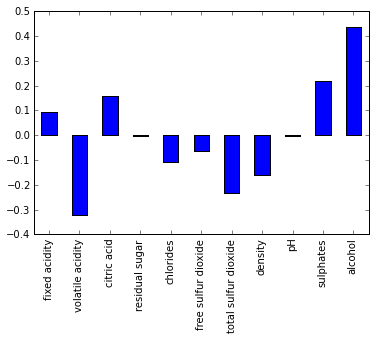

In [105]:
pcorr['Pearson Correlation'].plot(kind='bar')

# Maximal Information Coefficient:

In [49]:
#!pip install minepy

-Maximal information coefficient searches for optimal binning and turns mutual information score into a metric that lies in range [0;1].  
(Mutual information measures mutual dependence between variables, i.e. quantifies the "amount of information" obtained about one variable through the other variable).

[More info on MIC here](http://blog.datadive.net/selecting-good-features-part-i-univariate-selection/)  
[Mutual Information refresher](https://en.wikipedia.org/wiki/Mutual_information)

In [106]:
from minepy import MINE
m=MINE()

In [107]:
scores=[]
for i in range(len(x.columns)):
    m.compute_score(x.iloc[:,i],y)
    scores.append(m.mic())
maxIC=pd.DataFrame({"Maximal Information Coefficient":scores},index=[str(i) for i in x.columns.values])
maxIC

,Maximal Information Coefficient
fixed acidity,0.069389
volatile acidity,0.147521
citric acid,0.077837
residual sugar,0.063269
chlorides,0.091436
free sulfur dioxide,0.034867
total sulfur dioxide,0.131426
density,0.136607
pH,0.046885
sulphates,0.150187


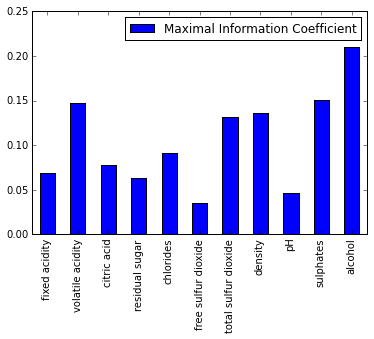

In [108]:
maxIC.plot(kind='bar')

# Model Based Ranking (Univariate Feature Selection):

In [53]:
from sklearn.cross_validation import cross_val_score

Determine each feature's contribution to the accuracy (or other scoring method) of your predictions: 

[More info here](http://blog.datadive.net/selecting-good-features-part-i-univariate-selection/)

In [54]:
scores = []
for i in range(len(x.columns)):
    scores.append(np.mean(cross_val_score(RandomForestClassifier(), x.iloc[:,i:i+1], y, scoring="accuracy", cv=5)))
CVDF=pd.DataFrame({"CV Score":scores},index=[str(i) for i in x.columns.values])
CVDF

,CV Score
fixed acidity,0.516532
volatile acidity,0.582853
citric acid,0.562849
residual sugar,0.522198
chlorides,0.527859
free sulfur dioxide,0.500300
total sulfur dioxide,0.542808
density,0.505921
pH,0.495298
sulphates,0.651683


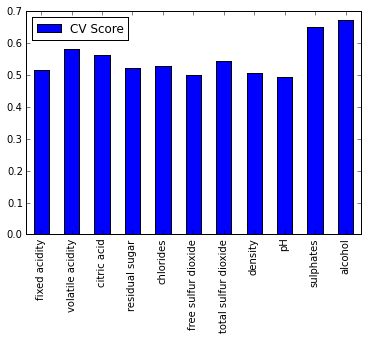

In [55]:
CVDF.plot(kind='bar')